[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-smallest-sets.ipynb)

# Conformal prediction for classification purpose
Inspired by the tutorial of Angelopoulos

In [33]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
!pip install -U --no-cache-dir gdown --pre

Requirement already up-to-date: gdown in /opt/anaconda3/lib/python3.7/site-packages (4.7.1)


## Data preparation

### Load the data

In [34]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

### Setting parameters for conformal prediction 

In [45]:
# Problem setup
n_cal = 1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

### Splitting the data

In [47]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n_cal + [0] * (smx.shape[0]-n_cal)) > 0
np.random.seed(42)
np.random.shuffle(idx)
cal_smx, test_smx = smx[idx,:], smx[~idx,:]
cal_labels, test_labels = labels[idx], labels[~idx]

### Understanding what is stored in the data

The first 10 labels in the calibration set are  [0 0 1 3 5 6 6 6 7 9]
The minimal label is  0
The maximal label is  999


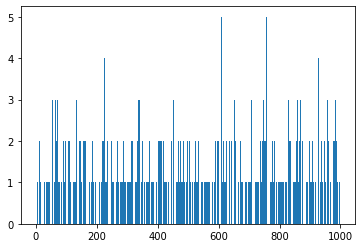

In [48]:
# Zoom on the labels in the calibration set
print("The first 10 labels in the calibration set are ", cal_labels[:10])
print("The minimal label is ",np.min(cal_labels))
print("The maximal label is ",np.max(cal_labels))
plt.hist(cal_labels,bins=1000);

The first 10 labels in the test set are  [0 0 0 0 0 0 0 0 0 0]
The minimal label is  0
The maximal label is  999


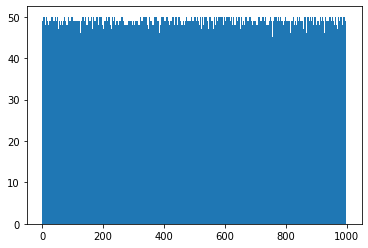

In [49]:
# Zoom on the labels in the test set
print("The first 10 labels in the test set are ", test_labels[:10])
print("The minimal label is ",np.min(test_labels))
print("The maximal label is ",np.max(test_labels))
plt.hist(test_labels,bins=1000);

In [50]:
print("The total number of different labels in the dataset:",len(np.unique(labels)))

The total number of different labels in the dataset: 1000


The sum of a row of cal_smx gives  0.9999999642681061


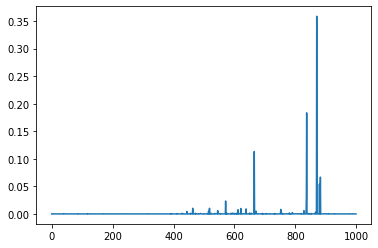

In [52]:
# Look at a row of cal_smx: this corresponds to the predicted probabilities 
# (the training has been already performed)
plt.plot(cal_smx[450])
print("The sum of a row of cal_smx gives ",np.sum(cal_smx[450]))

### A first way for conformal prediction

<div class="alert alert-block alert-info">
    1. For each calibration point, compute a score. <br>
    2. And then evaluate an empirical quantile of the calibration scores.  
</div> 



In [54]:
# 1: get conformal scores
cal_scores = 1-cal_smx[np.arange(n),cal_labels]


# 2: get adjusted quantile
q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
qhat = np.quantile(cal_scores, q_level, interpolation='higher')

<div class="alert alert-block alert-info">
    3. Form the prediction sets for the test set
</div> 

In [57]:
# 3: form prediction sets
prediction_sets = test_smx >= (1-qhat) 

<div class="alert alert-block alert-info">
    4. Compute the empirical coverage
</div> 

In [59]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),test_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.894469387755102


<div class="alert alert-block alert-info">
    5. Illustrate prediction sets for some points of the test set
</div> 

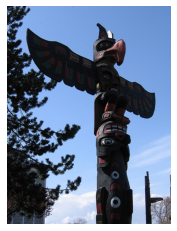

The prediction set is: ['totem pole']


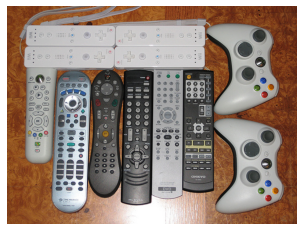

The prediction set is: ['remote control']


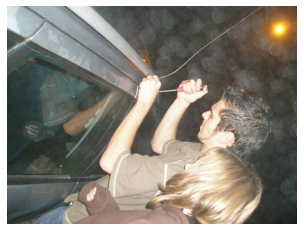

The prediction set is: ['weasel', 'black-footed ferret', 'barbershop', 'hair spray', 'seat belt', 'syringe']


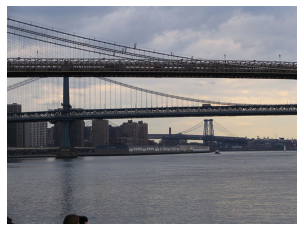

The prediction set is: ['pier', 'suspension bridge']


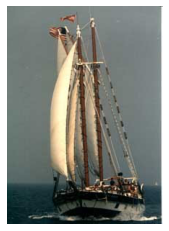

The prediction set is: ['schooner']


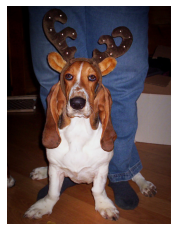

The prediction set is: ['Basset Hound']


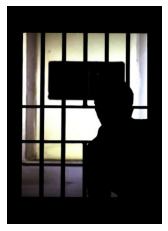

The prediction set is: ['prison']


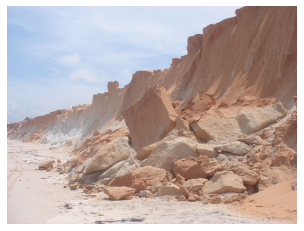

The prediction set is: ['cliff dwelling', 'cliff']


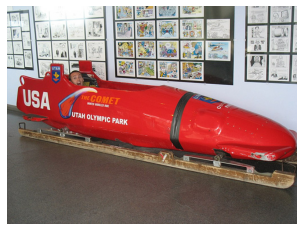

The prediction set is: ['bobsleigh']


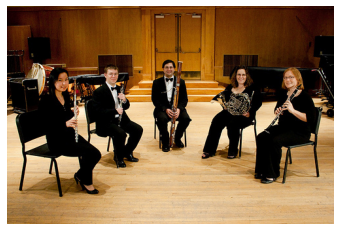

The prediction set is: ['bassoon', 'oboe']


In [11]:
# Making the labels human-readable
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

# Show some examples
example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

<div class="alert alert-block alert-success">This method leads to <b>small prediction sets</b>, but sacrifices <b>adaptivity</b>. </div>



## Towards more adaptive prediction sets 




In [96]:
# Get scores

# get for each row the position of the predicted probabilities in decreasing order
cal_pi = cal_smx.argsort(1)[:,::-1] #argsort in increasing order, so order reverting by [:,::-1] 

# form for each row the predicted probabilities in decreasing order
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)


# get the rank of the true label in the sorted predicted probabilities
cal_L = np.where(cal_pi == cal_labels[:,None])[1]

# compute the calibration scores (why minus something????)
cal_scores = cal_srt.cumsum(axis=1)[np.arange(n_cal),cal_L]

# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n_cal+1)*(1-alpha))/n_cal, interpolation='higher')


In [97]:
# Deploy
n_test = test_smx.shape[0]
test_pi = test_smx.argsort(1)[:,::-1] # sorting the predicted probabilities (softmax outputs) on the test set
test_srt = np.take_along_axis(test_smx,test_pi,axis=1) # reordering
#test_srt_cumsum = test_srt.cumsum(axis=1) # cumulative softmax outputs
indicators = test_srt.cumsum(axis=1) <= qhat
prediction_sets = np.take_along_axis(indicators,test_pi.argsort(axis=1),axis=1)

In [98]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(n_test),test_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")
print(f"The quantile is: {qhat}")

The empirical coverage is: 0.8972857142857142
The quantile is: 0.9998968839645386


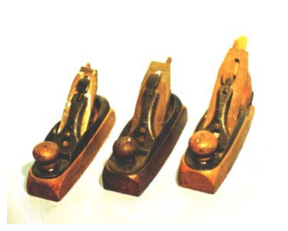

The prediction set is: ['hand plane']


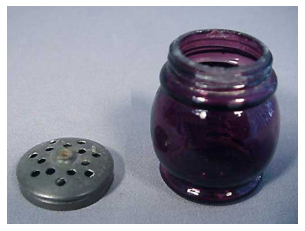

The prediction set is: ['barrel', 'face powder', 'loupe', 'pencil sharpener', 'pill bottle', 'hockey puck', 'salt shaker']


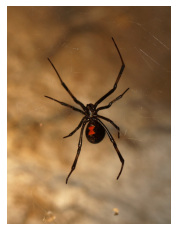

The prediction set is: ['harvestman', 'yellow garden spider', 'barn spider', 'southern black widow', 'spider web']


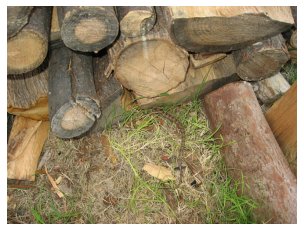

The prediction set is: ['mud turtle', 'terrapin', 'box turtle', 'triceratops', 'chainsaw', 'clogs', 'hammer', 'hatchet', 'sawmill', 'stone wall', 'bolete']


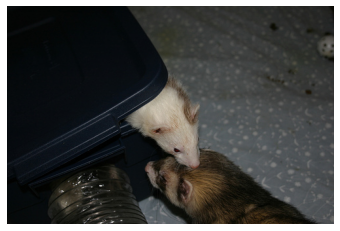

The prediction set is: ['weasel', 'mink', 'European polecat', 'black-footed ferret', 'skunk']


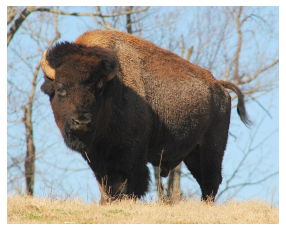

The prediction set is: ['bison']


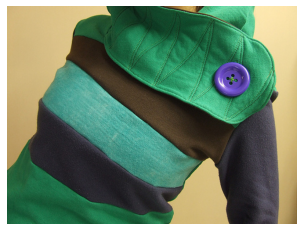

The prediction set is: ['backpack', 'buckle', 'cardigan', 'diaper', 'mail bag', 'pillow', 'poncho', 'purse', 'seat belt', 'scarf', 'sweatshirt', 'velvet', 'wool']


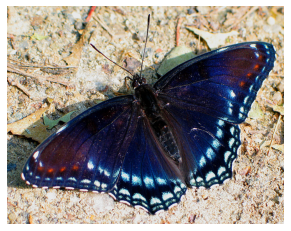

The prediction set is: ['red admiral', 'ringlet', 'monarch butterfly', 'sulphur butterfly', 'gossamer-winged butterfly']


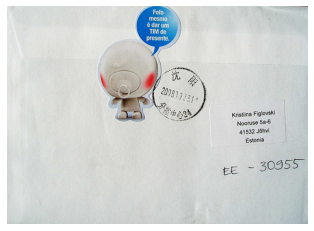

The prediction set is: ['ballpoint pen', 'envelope', 'handkerchief', 'necklace', 'safety pin', 'menu']


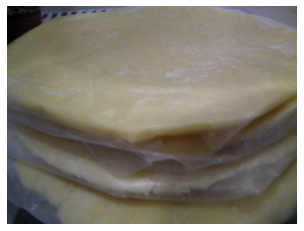

The prediction set is: ['frying pan', 'handkerchief', 'packet', 'spatula', 'baguette', 'bagel', 'cheeseburger', 'mashed potato', 'banana', 'dough', 'pot pie', 'burrito']


In [99]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    # Form the prediction set
    _smx = smx[img_index]
    _pi = np.argsort(_smx)[::-1]
    _srt = np.take_along_axis(_smx,_pi,axis=0)
    _srt_reg = _srt + reg_vec.squeeze()
    _srt_reg_cumsum = _srt_reg.cumsum()
    _ind = (_srt_reg_cumsum - np.random.rand()*_srt_reg) <= qhat if rand else _srt_reg_cumsum - _srt_reg <= qhat
    if disallow_zero_sets: _ind[0] = True
    prediction_set = np.take_along_axis(_ind,_pi.argsort(),axis=0)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

[Sadinle, Lei, Wasserman] https://arxiv.org/abs/1609.00451


[Notebook source](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-raps.ipynb)

In [63]:
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
lam_reg = 0.01
k_reg = 5
disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold
rand = True # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:] # create a row with 5 zeroes and the rest at 0.01

In [91]:
# Get scores

# get for each row the position of the predicted probabilities in decreasing order
cal_pi = cal_smx.argsort(1)[:,::-1] #argsort in increasing order, so order reverting by [:,::-1] 

# form for each row the predicted probabilities in decreasing order
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)

cal_srt_reg = cal_srt + reg_vec # addition row by row of 0 0 0 0 0 0.1 0.1 ....

# get the rank of the true label in the sorted predicted probabilities
cal_L = np.where(cal_pi == cal_labels[:,None])[1]

# compute the calibration scores (why minus something????)
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n_cal),cal_L] - np.random.rand(n_cal)*cal_srt_reg[np.arange(n),cal_L]

# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n_cal+1)*(1-alpha))/n_cal, interpolation='higher')


In [92]:
# Deploy
n_test = test_smx.shape[0]
test_pi = test_smx.argsort(1)[:,::-1] # sorting the predicted probabilities (softmax outputs) on the test set
test_srt = np.take_along_axis(test_smx,test_pi,axis=1) # reordering
test_srt_reg = test_srt + reg_vec # ???
test_srt_reg_cumsum = test_srt_reg.cumsum(axis=1) # cumulative softmax outputs
indicators = (test_srt_reg.cumsum(axis=1) - np.random.rand(n_test,1)*test_srt_reg) <= qhat if rand else test_srt_reg.cumsum(axis=1) - test_srt_reg <= qhat
if disallow_zero_sets: indicators[:,0] = True
prediction_sets = np.take_along_axis(indicators,test_pi.argsort(axis=1),axis=1)

In [93]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(n_test),test_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")
print(f"The quantile is: {qhat}")

The empirical coverage is: 0.8955510204081633
The quantile is: 0.9463601444480824


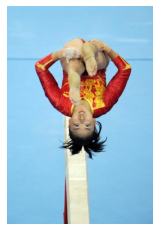

The prediction set is: ['balance beam', 'horizontal bar', 'parallel bars']


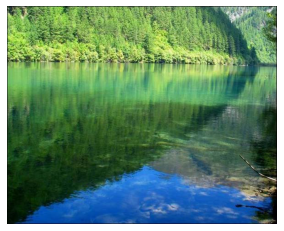

The prediction set is: ['canoe', 'lakeshore', 'valley']


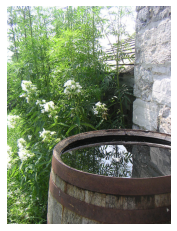

The prediction set is: ['rain barrel']


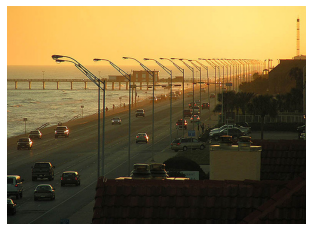

The prediction set is: ['baluster', 'chain-link fence', 'crane (machine)', 'fire screen sheet', 'flagpole', 'freight car', 'greenhouse', 'shopping cart', 'stage', 'traffic light']


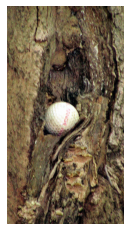

The prediction set is: ['golf ball']


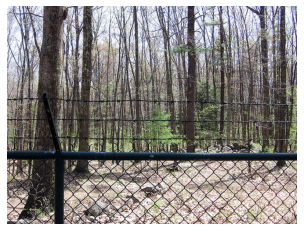

The prediction set is: ['chain-link fence']


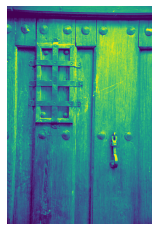

The prediction set is: ['combination lock', 'padlock', 'safe', 'screw', 'switch']


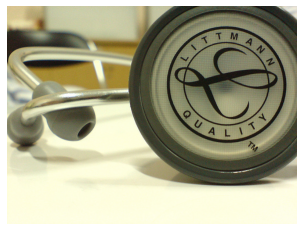

The prediction set is: ['stethoscope']


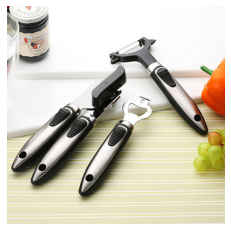

The prediction set is: ['can opener', 'corkscrew', 'hammer']


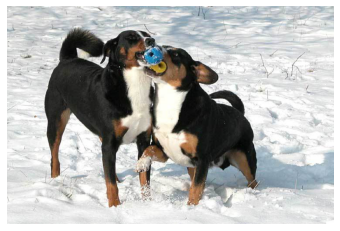

The prediction set is: ['Appenzeller Sennenhund', 'Entlebucher Sennenhund']


In [94]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    # Form the prediction set
    _smx = smx[img_index]
    _pi = np.argsort(_smx)[::-1]
    _srt = np.take_along_axis(_smx,_pi,axis=0)
    _srt_reg = _srt + reg_vec.squeeze()
    _srt_reg_cumsum = _srt_reg.cumsum()
    _ind = (_srt_reg_cumsum - np.random.rand()*_srt_reg) <= qhat if rand else _srt_reg_cumsum - _srt_reg <= qhat
    if disallow_zero_sets: _ind[0] = True
    prediction_set = np.take_along_axis(_ind,_pi.argsort(),axis=0)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")